In [40]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [41]:
conn = sqlite3.connect('Shared DC2 Group 19\\database_final.db')

query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight = pd.read_sql(query_sun, conn)
df_housing = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from dataabse and storing in DF
conn.close()

In [42]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= 2013) & (df_unemployment['Month'].dt.year <= 2019)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [43]:
df_burglary = df_burglary_all.drop(columns=['Reported by', 'Falls within']).dropna()
df_bar=df_burglary[df_burglary['LSOA name'].str.contains('Barnet')]
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= 2013) & (df_bar['Month'].dt.year <= 2019)]
#Filtering for Barnet data, 2013 included for time lag

C:\Users\shash\AppData\Local\Temp\ipykernel_29436\3804163310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Month'] = pd.to_datetime(df_bar['Month'])
C:\Users\shash\AppData\Local\Temp\ipykernel_29436\3804163310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bar['Year']= df_bar['Month'].dt.year


In [44]:
df_sunlight['Month'] = pd.to_datetime(df_sunlight['Year-Month'])
df_sunlight=df_sunlight.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col

In [45]:
df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe

In [46]:
burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [47]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing, how='left', on=['LSOA code']).dropna() #Merging Berg and Housing
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
temp_merged_clean = df_merged_2.drop(columns=['Missing', 'LSOA name']) #Drop unnecessary Cols

In [48]:
lags = [1, 3, 6, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [49]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

,LSOA code,Month,Total Burglaries,Owned or shared ownership,Private Rented or lives rent free,Social Rented,Proportion social,Proportion rented,Detached whole house or bungalow,Semi-detached whole house or bungalow,...,LSOA_E01000316,LSOA_E01000317,LSOA_E01000318,LSOA_E01000319,LSOA_E01000320,LSOA_E01000321,LSOA_E01000322,LSOA_E01000323,LSOA_E01000324,Month_Int
0,E01000115,2013-04-01,2,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,4
1,E01000115,2013-05-01,1,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,5
2,E01000115,2013-07-01,1,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,7
3,E01000115,2013-08-01,1,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,8
4,E01000115,2013-11-01,2,435.0,45.0,0.0,0.0,0.09375,135.0,335.0,...,0,0,0,0,0,0,0,0,0,11


In [50]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= 2014) & (df_temp_merged_clean_dummies['Month'].dt.year <= 2018)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year == 2019)] 
#Filtering test and train based on time span of 2014 to 2018 for Train and 2019 for Test

In [51]:
#X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
X_train = df_temp_merged_clean_train[["Proportion rented", "Month_Int", "Sunlight", "Unemployment", "Unemployment_PctChange_6m", "Unemployment_PctChange_3m", "Unemployment_PctChange_12m", "Total_Burglaries_PctChange_12m", "Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_3m"]] #What you give to the model
y_train = df_temp_merged_clean_train["Total Burglaries"] #What needs to be predicted
#X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "Month", "LSOA code"], axis = 1)
X_test = df_temp_merged_clean_test[[ "Proportion rented", "Month_Int", "Sunlight", "Unemployment", "Unemployment_PctChange_6m", "Unemployment_PctChange_3m", "Unemployment_PctChange_12m", "Total_Burglaries_PctChange_12m", "Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_3m"]] #What you give to the model
y_test = df_temp_merged_clean_test["Total Burglaries"] #Waht needs to be predicted

In [52]:
model = XGBRegressor()
model.fit(X_train, y_train)
#Fitting data to model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

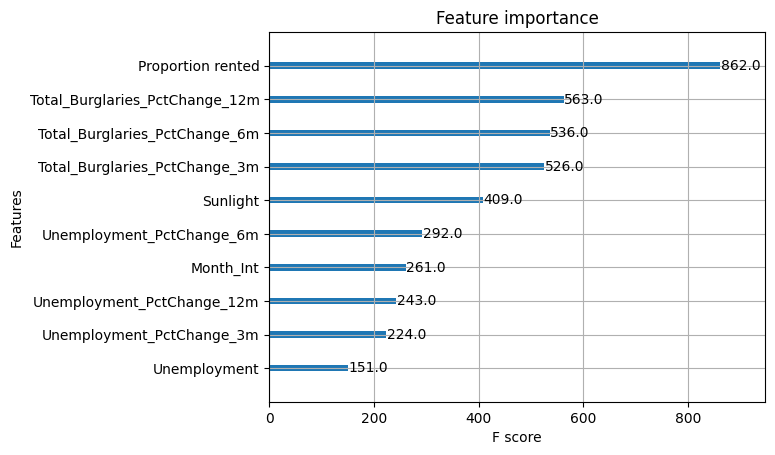

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=15)
#Plotting the most important featurs

In [54]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
predictions = model.predict(X_test)

In [63]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train Value,Test Value
0,MSE,0.031622,0.136069
1,MAE,0.085942,0.164439
2,R^2,0.982942,0.919869
3,MedAE,0.044528,0.075148
